Splitting the dataset

In [31]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader, random_split
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision import transforms

In [32]:
# Load the dataset
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# from google.colab import drive
# drive.mount('/content/drive')
# dataset = ImageFolder(root='/content/drive/My Drive/CNP Dataset/', transform=transform)
dataset = ImageFolder(root='G:/MISC files/Research/SoftySofty', transform=transform)

In [33]:
# Set a manual seed for reproducibility
seed = 35
torch.manual_seed(seed)

# Get labels and split indices
labels = dataset.targets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=seed)  # 10% for testing
train_val_idx, test_idx = next(sss.split(range(len(labels)), labels))

# Convert train_val_idx to a list
train_val_idx = list(train_val_idx)

# Split train_val_idx further into train_idx and val_idx
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1111, random_state=seed)  # 10% of total data for validation
train_idx, val_idx = next(sss.split(train_val_idx, [labels[i] for i in train_val_idx]))

# Create subsets
train_dataset = Subset(dataset, [train_val_idx[i] for i in train_idx])
val_dataset = Subset(dataset, [train_val_idx[i] for i in val_idx])
test_dataset = Subset(dataset, test_idx)

# DataLoader
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


# Print dataset sizes
print("Number of batches in training", len(train_loader))
print("Number of batches in testing", len(test_loader))
print("Number of batches in validation", len(val_loader))

print("Total training images: ", len(train_loader.dataset))
print("Total validation images: ", len(val_loader.dataset))
print("Total testing images: ", len(test_loader.dataset))

Number of batches in training 41
Number of batches in testing 5
Number of batches in validation 5
Total training images:  4182
Total validation images:  523
Total testing images:  523


Prepare the data with stratification and manual seed.

Training Samples:


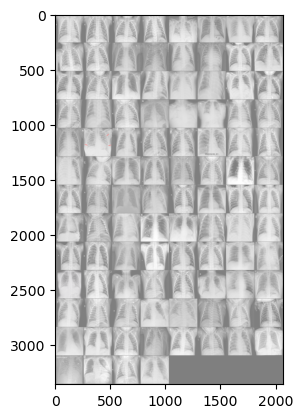

Validation Samples:


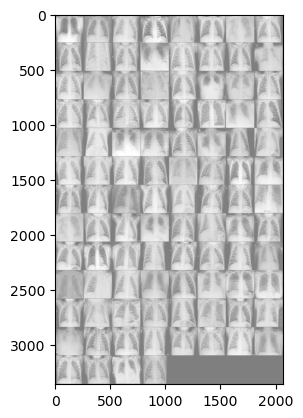

Test Samples:


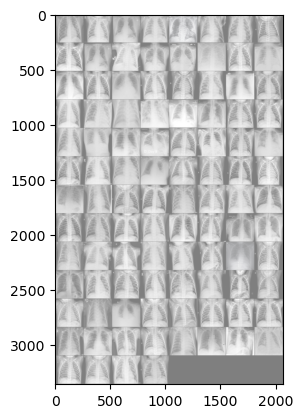

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
for images, labels in train_loader:
    print("Training Samples:")
    imshow(torchvision.utils.make_grid(images))
    break  # we break the loop after the first batch

# Get some random validation images
for images, labels in val_loader:
    print("Validation Samples:")
    imshow(torchvision.utils.make_grid(images))
    break  # we break the loop after the first batch

# Get some random test images
for images, labels in test_loader:
    print("Test Samples:")
    imshow(torchvision.utils.make_grid(images))
    break  # we break the loop after the first batch



BiLSTM classifier model

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

# Hyperparameters
sequence_length = 256 * 3
input_size = 256
hidden_size = 128
num_layers = 3
num_classes = 3
batch_size = 100
learning_rate = 0.001
dropout_rate = 0.5

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Define BiLSTM model
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

# Instantiate BiLSTM model
bilstm_model = BiLSTM(input_size, hidden_size, num_layers, num_classes, dropout_rate).to(device)
bilstm_optimizer = optim.Adam(bilstm_model.parameters(), lr=learning_rate)
scheduler = StepLR(bilstm_optimizer, step_size=10, gamma=0.1)

# Function to calculate accuracy
def calculate_accuracy(y_true, y_pred):
    y_pred = torch.log_softmax(y_pred, dim=1).argmax(dim=1)
    correct_pred = (y_true == y_pred).float()
    accuracy = correct_pred.sum() / len(correct_pred)
    return accuracy * 100

# Training loop (you can also use a separate validation DataLoader)
num_epochs = 40
best_val_loss = float('inf')
for epoch in range(num_epochs):
    bilstm_model.train()
    train_accuracy_list = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        bilstm_optimizer.zero_grad()
        outputs = bilstm_model(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        bilstm_optimizer.step()

        # Calculate train accuracy
        train_accuracy = calculate_accuracy(labels, outputs)
        train_accuracy_list.append(train_accuracy)

    # Validation
    val_loss = 0
    val_accuracy_list = []
    bilstm_model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            outputs = bilstm_model(images)
            val_loss += nn.CrossEntropyLoss()(outputs, labels).item()

            # Calculate validation accuracy
            val_accuracy = calculate_accuracy(labels, outputs)
            val_accuracy_list.append(val_accuracy)

    # Print train and validation accuracy for each epoch
    print(f'Epoch: {epoch+1}, Train Accuracy: {torch.stack(train_accuracy_list).mean():.2f}%, Val Accuracy: {torch.stack(val_accuracy_list).mean():.2f}%')

    # Early stopping
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    # else:
    #     print("Early stopping")
    #     break

    # Step the scheduler
    scheduler.step()

# Evaluation
bilstm_model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = bilstm_model(images)
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy (BiLSTM): {accuracy * 100:.2f}%')


Epoch: 1, Train Accuracy: 56.66%, Val Accuracy: 67.40%
Epoch: 2, Train Accuracy: 64.41%, Val Accuracy: 72.40%
Epoch: 3, Train Accuracy: 69.20%, Val Accuracy: 73.60%
Epoch: 4, Train Accuracy: 72.27%, Val Accuracy: 74.60%
Epoch: 5, Train Accuracy: 71.46%, Val Accuracy: 73.60%
Epoch: 6, Train Accuracy: 69.83%, Val Accuracy: 75.80%
Epoch: 7, Train Accuracy: 73.98%, Val Accuracy: 78.20%
Epoch: 8, Train Accuracy: 75.93%, Val Accuracy: 76.80%
Epoch: 9, Train Accuracy: 75.44%, Val Accuracy: 80.20%
Epoch: 10, Train Accuracy: 79.29%, Val Accuracy: 80.20%
Epoch: 11, Train Accuracy: 83.37%, Val Accuracy: 87.20%
Epoch: 12, Train Accuracy: 84.54%, Val Accuracy: 87.80%
Epoch: 13, Train Accuracy: 86.05%, Val Accuracy: 89.40%
Epoch: 14, Train Accuracy: 86.78%, Val Accuracy: 89.80%
Epoch: 15, Train Accuracy: 87.90%, Val Accuracy: 86.40%
Epoch: 16, Train Accuracy: 88.20%, Val Accuracy: 89.40%
Epoch: 17, Train Accuracy: 88.05%, Val Accuracy: 88.20%
Epoch: 18, Train Accuracy: 88.22%, Val Accuracy: 91.40%
E

BiRNN classifier model

In [ ]:
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

# Instantiate BiRNN model
birnn_model = BiRNN(input_size, hidden_size, num_layers, num_classes, dropout_rate).to(device)
birnn_optimizer = optim.Adam(birnn_model.parameters(), lr=learning_rate)
scheduler = StepLR(birnn_optimizer, step_size=10, gamma=0.1)

# Function to calculate accuracy
def calculate_accuracy(y_true, y_pred):
    y_pred = torch.log_softmax(y_pred, dim=1).argmax(dim=1)
    correct_pred = (y_true == y_pred).float()
    accuracy = correct_pred.sum() / len(correct_pred)
    return accuracy * 100

# Training loop (you can also use a separate validation DataLoader)
num_epochs = 30
best_val_loss = float('inf')
for epoch in range(num_epochs):
    birnn_model.train()
    train_accuracy_list = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        birnn_optimizer.zero_grad()
        outputs = birnn_model(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        birnn_optimizer.step()

        # Calculate train accuracy
        train_accuracy = calculate_accuracy(labels, outputs)
        train_accuracy_list.append(train_accuracy)

    # Validation
    val_loss = 0
    val_accuracy_list = []
    birnn_model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            outputs = birnn_model(images)
            val_loss += nn.CrossEntropyLoss()(outputs, labels).item()

            # Calculate validation accuracy
            val_accuracy = calculate_accuracy(labels, outputs)
            val_accuracy_list.append(val_accuracy)

    # Print train and validation accuracy for each epoch
    print(f'Epoch: {epoch+1}, Train Accuracy: {torch.stack(train_accuracy_list).mean():.2f}%, Val Accuracy: {torch.stack(val_accuracy_list).mean():.2f}%')
    scheduler.step()